# Encoder-only architecture - BERT 

## 1. Introduction

This notebook will walk through the basics of the BERT architecture, how its tokenizer works, and how positional encoding is applied. 

BERT (Bidirectional Encoder Representations from Transformers) is a transformer-based model designed for NLP tasks. It has multiple layers of encoders, each containing:
- Self-attention mechanism
- Feed-forward neural networks
- Layer normalization and residual connections

We'll start by visualizing the structure of BERT's encoders.

In [24]:
from transformers import BertModel, BertTokenizer
import torch
import matplotlib.pyplot as plt

# Load pre-trained BERT model
model = BertModel.from_pretrained('bert-base-uncased')
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

### 1. **Embeddings Layer**
The embeddings layer is responsible for creating representations of the input tokens. It includes:

- **Word Embeddings**: Maps each of the 30,522 vocabulary tokens to a 768-dimensional vector.
- **Position Embeddings**: Adds positional information to each token using a 512-length sequence of 768-dimensional vectors.
- **Token Type Embeddings**: Adds embeddings to distinguish between segments (e.g., Sentence A and Sentence B) with 2 different token types.
- **Layer Normalization and Dropout**: Normalizes the embeddings and applies dropout to prevent overfitting.

### 2. **BERT Encoder**
BERT's encoder is composed of 12 identical layers (for BERT-base, 24 for BERT-large), each called a **BERT Layer**. Each BERT layer consists of the following components:

- **Self-Attention**:
  - The self-attention mechanism is divided into multiple heads, each computing its own attention scores using three linear projections: Query (`Q`), Key (`K`), and Value (`V`). 

- **Self-Attention Output**:
  - The output of the self-attention mechanism is passed through a dense (linear) layer that projects the output back to the original dimension of 768.

- **Feed-Forward Neural Network**:
  - Each BERT layer includes a position-wise feed-forward network that processes each token independently after the self-attention mechanism.
  - The feed-forward network consists of two dense layers:
    - The **intermediate layer** expands the dimensionality from 768 to 3072 using a linear transformation and applies a **GELU** (Gaussian Error Linear Unit) activation function for non-linearity.
    - The **output layer** projects the 3072-dimensional vector back down to 768 dimensions, matching the input size.

- **Residual Connections**:
  - BERT uses residual (skip) connections around the self-attention and feed-forward components. The input to each sub-layer is added to its output. 

### **BERT Tokenization with WordPiece**

BERT uses a **WordPiece tokenizer**, a subword tokenization technique. This tokenizer splits words into smaller subwords or tokens, allowing BERT to represent rare words as combinations of common subwords and prefixes.

#### **How WordPiece Works**

The WordPiece tokenizer splits a word based on its frequency in the training data:
- **Common Words**: If a word is frequently used in the training corpus, it will likely be stored as a single token. For example, words like "hello" or "sentence" are common enough to exist in BERT's vocabulary as single tokens.
- **Rare or Unknown Words**: For less common or out-of-vocabulary words, the tokenizer will break them into subword units or prefixes. These subwords are often combined with a special prefix `##` to indicate they are part of a larger word. 

Let’s see how the WordPiece tokenizer processes a sample sentence using BERT’s tokenizer.


In [25]:
# Load pre-trained tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

sentence = "hello, this is a sentence!"

# Tokenize the sentence
tokens = tokenizer.tokenize(sentence)
print("Tokens:", tokens)

# Convert tokens to IDs
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print("Token IDs:", token_ids)

Tokens: ['hello', ',', 'this', 'is', 'a', 'sentence', '!']
Token IDs: [7592, 1010, 2023, 2003, 1037, 6251, 999]


/home/csavelli/miniconda3/envs/hf_env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [26]:
sentence = "This sentence is too cumbersome!"

# Tokenize the sentence
tokens = tokenizer.tokenize(sentence)
print("Tokens:", tokens)

# Convert tokens to IDs
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print("Token IDs:", token_ids)

Tokens: ['this', 'sentence', 'is', 'too', 'cum', '##bers', '##ome', '!']
Token IDs: [2023, 6251, 2003, 2205, 13988, 17198, 8462, 999]


### Special Tokens in BERT

BERT uses several special tokens to structure the input and help the model understand the context and relationships between sequences. These tokens play an important role in various NLP tasks such as sentence classification, next sentence prediction, and more.

#### 1. **[CLS] Token** (Classification Token)
- The `[CLS]` token is added at the beginning of every input sequence. 
- BERT uses this token as a representation of the entire sequence. The hidden state of the `[CLS]` token after passing through BERT can be used for classification tasks (we are going to use it later!).

#### 2. **[PAD] Token** (Padding Token)
- The `[PAD]` token is used to pad sequences so they all have the same length within a batch. The attention mechanism then ignores these `[PAD]` tokens.

In [27]:
sentence1 = "This is a short sentence."
tokens_single = tokenizer(sentence1, return_tensors='pt', padding='max_length', max_length=10)

# Display tokenized output and input IDs
print("Single Sentence Tokenization:")
print("Tokens:", tokenizer.convert_ids_to_tokens(tokens_single['input_ids'][0]))
print("Input IDs:", tokens_single['input_ids'][0])

Single Sentence Tokenization:
Tokens: ['[CLS]', 'this', 'is', 'a', 'short', 'sentence', '.', '[SEP]', '[PAD]', '[PAD]']
Input IDs: tensor([ 101, 2023, 2003, 1037, 2460, 6251, 1012,  102,    0,    0])


#### 3. **[SEP] Token** (Separator Token)
- The `[SEP]` token is used to separate segments (sentences) in BERT's input.
- It is especially important for tasks like Next Sentence Prediction (NSP) where BERT needs to understand the relationship between two sentences.
- It is also added at the end of the sequence to indicate its termination.

In [28]:
sentence2 = "But now it is a little longer."
tokens_pair = tokenizer(sentence1, sentence2, return_tensors='pt', padding='max_length', max_length=20)

# Display tokenized output and input IDs
print("\nTwo Sentences Tokenization:")
print("Tokens:", tokenizer.convert_ids_to_tokens(tokens_pair['input_ids'][0]))
print("Input IDs:", tokens_pair['input_ids'][0])


Two Sentences Tokenization:
Tokens: ['[CLS]', 'this', 'is', 'a', 'short', 'sentence', '.', '[SEP]', 'but', 'now', 'it', 'is', 'a', 'little', 'longer', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]']
Input IDs: tensor([ 101, 2023, 2003, 1037, 2460, 6251, 1012,  102, 2021, 2085, 2009, 2003,
        1037, 2210, 2936, 1012,  102,    0,    0,    0])


#### 4. **[MASK] Token**
- The `[MASK]` token is used during training for the Masked Language Modeling (MLM) task, where a percentage of tokens are masked and the model must predict them based on the context.
- This token is rarely used during inference but is crucial in pre-training BERT.

In [29]:
# show a mask token 
mask_token = tokenizer.mask_token 
mask_token_id = tokenizer.convert_tokens_to_ids(mask_token)

# Encode a text
text = "I do not know how the sentence will end."
encoded_input = tokenizer(text, return_tensors='pt')

mask_position = 9
encoded_input['input_ids'][0, mask_position] = mask_token_id

print("Tokens:", tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0]))

Tokens: ['[CLS]', 'i', 'do', 'not', 'know', 'how', 'the', 'sentence', 'will', '[MASK]', '.', '[SEP]']


### Positional Encodings in Transformers

There are two common approaches for implementing positional encodings:

#### 1. **Static Sinusoidal Positional Encodings**

- The one that we already saw in the previous laboratory. 
- **Advantages**:
  - This method requires no additional parameters or learning during training.
  - The same encoding can be applied across sequences of any length without adjustment.
- **Disadvantages**:
  - Since these encodings are static, they might not be as flexible or as specific as learned positional embeddings, which can adapt better to the data.

#### 2. **Learned Positional Embeddings**

- Instead of using a fixed, pre-defined encoding, learned positional embeddings are trained as part of the model, similar to how word embeddings are learned.
- The model learns a set of positional vectors, where each vector corresponds to a position in the sequence (e.g., position 0, position 1, etc.). 
- **Advantages**:
  - The model can change positional encodings to the data it is trained on, potentially capturing positional relationships more effectively.
- **Disadvantages**:
  - Learned positional embeddings introduce additional parameters, which increases the model size and training complexity.
  - The learned embeddings are limited to a maximum sequence length (e.g., 512 for BERT).

BERT uses the second approach: **learned positional embeddings**. During the training process, BERT learns a set of positional vectors corresponding to token positions up to a maximum length (typically 512). These embeddings are added to the token embeddings to provide position information.


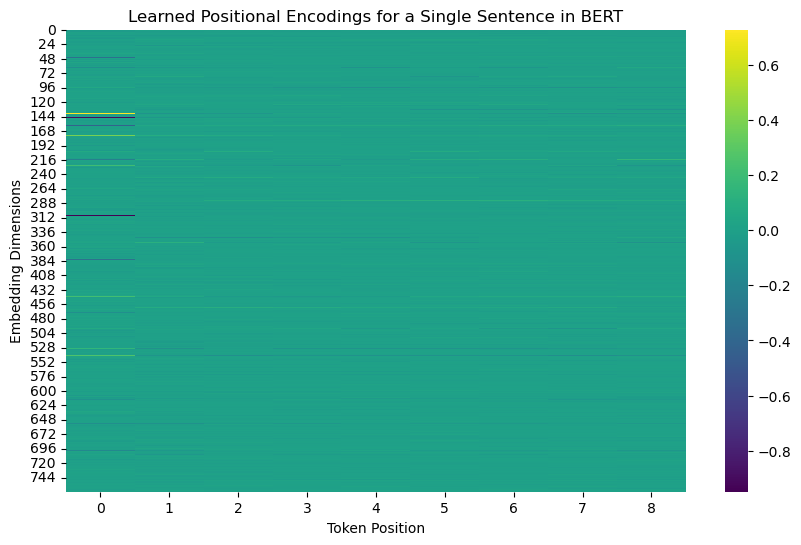

In [30]:
from transformers import BertModel, BertTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Example sentence
sentence = "hello, this is a sentence!"

# Tokenize the sentence and get input IDs
inputs = tokenizer(sentence, return_tensors='pt')
input_ids = inputs['input_ids']

# Get the learned positional encodings from the BERT model
positional_encodings = model.embeddings.position_embeddings.weight.detach().cpu()

# Extract the positional encodings for the tokens in the sentence
sentence_length = input_ids.shape[1]
sentence_positional_encodings = positional_encodings[:sentence_length]

# Convert to numpy for easier manipulation
sentence_positional_encodings = sentence_positional_encodings.numpy()

# Plot the positional encodings for the sentence
plt.figure(figsize=(10, 6))
sns.heatmap(sentence_positional_encodings.T, cmap='viridis', cbar=True)
plt.xlabel('Token Position')
plt.ylabel('Embedding Dimensions')
plt.title('Learned Positional Encodings for a Single Sentence in BERT')
plt.show()


In [31]:
positional_encodings.shape

torch.Size([512, 768])

## 2. BERT Pre-Training Tasks

BERT is pre-trained using two primary tasks: **Masked Language Modeling (MLM)** and **Next Sentence Prediction (NSP)**. 

#### 1. **Masked Language Modeling (MLM)**

- In the MLM task, a token is replaced with the special `[MASK]` token and the model then tries to predict the original token based on the surrounding context. 
- BERT learns to understand the context and fill in the blanks, which helps it develop contextualized embeddings for each word. 

#### 2. **Next Sentence Prediction (NSP)**

- In addition to MLM, BERT is trained to predict whether one sentence logically follows another. This is called the **Next Sentence Prediction (NSP)** task.
- BERT takes two sentences (or segments) as input and must determine if the second sentence is a continuation of the first.


In [32]:
from transformers import BertForMaskedLM, BertForNextSentencePrediction
import torch

# Load pre-trained BERT model and tokenizer
model_mlm = BertForMaskedLM.from_pretrained('bert-base-uncased')

sentence = "I want to eat a [MASK]."
inputs = tokenizer(sentence, return_tensors='pt')

with torch.no_grad():
    outputs = model_mlm(**inputs)
    predictions = outputs.logits

masked_index = (inputs['input_ids'] == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]
top_k = 5
top_k_probabilities, top_k_indices = torch.topk(predictions[0, masked_index, :], top_k, dim=-1)

top_k_probabilities = top_k_probabilities.squeeze().tolist()
top_k_indices = top_k_indices.squeeze().tolist()

top_k_tokens = [tokenizer.decode([idx]) for idx in top_k_indices]

print("\nMasked Language Modeling:")
print("Input tokens:", tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))
print("\nTop 5 Predictions:")
for token, prob in zip(top_k_tokens, top_k_probabilities):
    print(f"Token: {token}, Probability: {prob:.4f}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Masked Language Modeling:
Input tokens: ['[CLS]', 'i', 'want', 'to', 'eat', 'a', '[MASK]', '.', '[SEP]']

Top 5 Predictions:
Token: little, Probability: 10.2418
Token: bite, Probability: 9.8704
Token: burger, Probability: 9.0154
Token: lot, Probability: 8.9455
Token: sandwich, Probability: 8.6518


In [33]:
model_nsp = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')

sentence_a = "Sherlock Holmes is my favorite detective"
sentence_b = "I read all the books about him!"
inputs_nsp = tokenizer(sentence_a, sentence_b, return_tensors='pt')

print("Tokens:", tokenizer.convert_ids_to_tokens(inputs_nsp['input_ids'][0]))

# Get NSP predictions
with torch.no_grad():
    outputs_nsp = model_nsp(**inputs_nsp)
    logits = outputs_nsp.logits
    nsp_prediction = torch.argmax(logits).item()

nsp_label = "True" if nsp_prediction == 0 else "False"
print(f"Prediction: {nsp_label}")

Tokens: ['[CLS]', 'sherlock', 'holmes', 'is', 'my', 'favorite', 'detective', '[SEP]', 'i', 'read', 'all', 'the', 'books', 'about', 'him', '!', '[SEP]']
Prediction: True


In [34]:
sentence_c = "The stock market saw a significant increase yesterday, surprising many investors."
inputs_nsp_false = tokenizer(sentence_a, sentence_c, return_tensors='pt')

print("Tokens:", tokenizer.convert_ids_to_tokens(inputs_nsp_false['input_ids'][0]))

# Get NSP predictions
with torch.no_grad():
    outputs_nsp_false = model_nsp(**inputs_nsp_false)
    logits_false = outputs_nsp_false.logits
    nsp_prediction_false = torch.argmax(logits_false).item()

nsp_label_false = "True" if nsp_prediction_false == 0 else "False"
print(f"Prediction: {nsp_label_false}")

Tokens: ['[CLS]', 'sherlock', 'holmes', 'is', 'my', 'favorite', 'detective', '[SEP]', 'the', 'stock', 'market', 'saw', 'a', 'significant', 'increase', 'yesterday', ',', 'surprising', 'many', 'investors', '.', '[SEP]']
Prediction: False


In this step, we define a sample text that we will use for sentiment analysis **TODO**

The tokenizer is then used to process the input text. The `tokenizer` converts the raw sentence into a format that the model can understand by breaking it down into tokens and converting them into numerical IDs. In this case, the method `tokenizer(text, return_tensors="pt", padding=True, truncation=True)` ensures that the output is in the correct tensor format (`return_tensors="pt"` for PyTorch), applies padding to ensure consistent input length across batches, and truncates the text if it exceeds the model's maximum sequence length. The output includes both **input IDs**, which are the tokenized numerical representations of the words, and an **attention mask**, which indicates which tokens should be attended to (where `1` signifies real tokens and `0` marks padding tokens). 

This ensures that only the relevant tokens are processed by the model, with the attention mask ignoring any padding that may have been added. By printing both the token IDs and the attention mask, we can inspect how the text has been prepared for model inference.

In [35]:
# Define a sample text for sentiment analysis
text = "The dog ate the food because it was hungry"

# Tokenize the input text
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

# Print the tokens
print("Tokens:", inputs["input_ids"])
print("Attention Mask:", inputs["attention_mask"])

Tokens: tensor([[ 101, 1996, 3899, 8823, 1996, 2833, 2138, 2009, 2001, 7501,  102]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


## 3. Encoder Attention Mechanism

The attention mechanism is a crucial component of BERT’s encoder architecture. It allows the model to weigh the importance of each token in a sequence relative to all other tokens from both the left and right sides, making it **bidirectional**.

#### 1. **Self-Attention Mechanism**
- In BERT, each token in a sequence attends to all other tokens, including itself. This is known as **self-attention**. The goal is to understand the relationship and relevance of each token within the entire sequence.
- The attention mechanism allows BERT to dynamically weigh the relevance of each word in the context of the entire sequence. This helps BERT generate contextualized word representations that take into account the entire sentence.


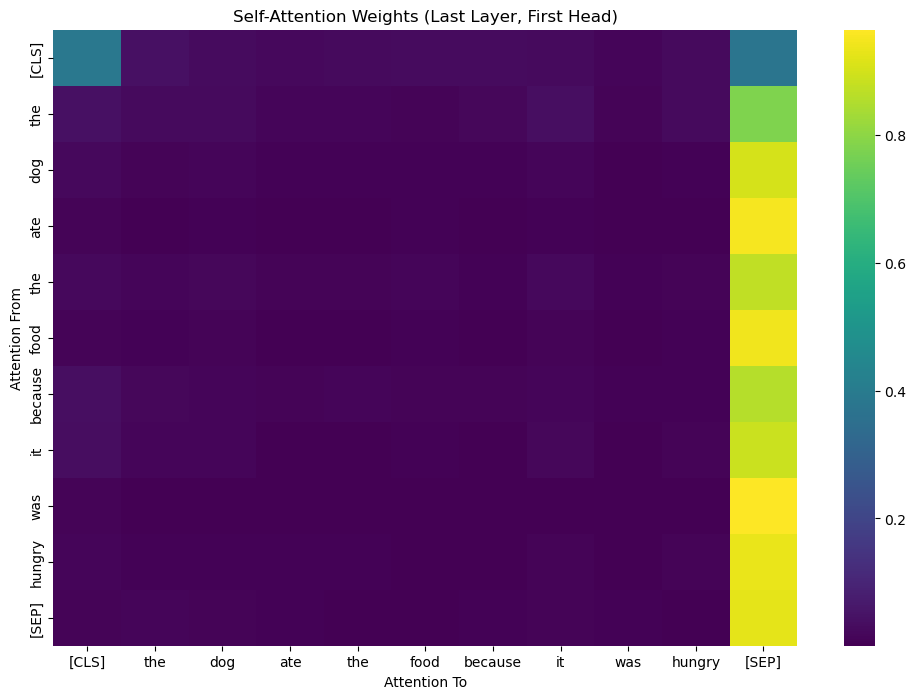

In [43]:
from transformers import BertModel, BertTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load pre-trained BERT model and tokenizer
model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)

sentence = "The dog ate the food because it was hungry"

inputs = tokenizer(sentence, return_tensors='pt')

outputs = model(**inputs)
attention = outputs.attentions  # This returns a list of attention matrices

# Select the attention from the last layer and the first attention head
attention_layer = attention[-1]  # Last layer
attention_head = attention_layer[0, 0].detach().numpy()  # First batch and first head

# Get the tokens for the sentence
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Exclude the last token (usually the [SEP] token)
# attention_head = attention_head[:-1, :-1]
# tokens = tokens[:-1]

# Plot the attention weights
plt.figure(figsize=(12, 8))
sns.heatmap(attention_head, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
plt.xlabel('Attention To')
plt.ylabel('Attention From')
plt.title('Self-Attention Weights (Last Layer, First Head)')
plt.show()

## 4. BERT Fine-Tuning

While BERT is pre-trained on general tasks like Masked Language Modeling (MLM) and Next Sentence Prediction (NSP), its real power comes from **fine-tuning** on specific tasks. Fine-tuning involves training the pre-trained BERT model on a smaller dataset for a particular NLP task such as sentiment analysis, text classification, named entity recognition, or question answering.

The fine-tuning process typically involves:
- Adding a task-specific classification head (a simple dense layer) on top of the pre-trained BERT model.
- Training the entire model (including both the BERT base and the new classification head) on your labeled dataset.
- The fine-tuning process adjusts the weights of the model so that it performs well on the new task, while still retaining the knowledge it gained during pre-training.

In this case, we’ll fine-tune BERT for a sentiment classification task. The model will be trained to classify movie reviews as positive or negative.

In [37]:
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score

# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/home/csavelli/miniconda3/envs/hf_env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [38]:
# Function to compute accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    return {"accuracy": accuracy}

In [39]:
# Load a sentiment analysis dataset
dataset = load_dataset('imdb')
train_dataset = dataset['train'].shuffle(seed=42).select(range(2000))
test_dataset = dataset['test'].shuffle(seed=42).select(range(1000))

In [40]:
# Tokenize the dataset
def tokenize_function(example):
    return tokenizer(example['text'], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

In [41]:
batch_size = 32
num_train_epochs = 2

learning_rate = 2e-5
weight_decay = 0.01

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,
    logging_dir='./logs',  # Directory for storing logs
    logging_steps=10,  # Log every 10 steps
)

In [42]:
# Initialize the Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Fine-tune the model
results = trainer.train()
print(f"Accuracy on the train set: {results.metrics['eval_accuracy']:.2f}")

/home/csavelli/miniconda3/envs/hf_env/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.425100,0.349347,0.869000
2,0.254800,0.301222,0.883000


/home/csavelli/miniconda3/envs/hf_env/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/csavelli/miniconda3/envs/hf_env/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


KeyError: 'eval_accuracy'

In [23]:
# Evaluate the model
results = trainer.evaluate()
print(f"Accuracy on the test set: {results['eval_accuracy']:.2f}")

/home/csavelli/miniconda3/envs/hf_env/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Evaluation Results: 0.89
